## Imports

In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

* Helper Functions

In [2]:
import math

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)


def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    
    if len(img.shape) > 2: 
        channel_count = img.shape[2] # 3 or 4 depending on your image
        mask_color = (255,) * channel_count
    else:
        mask_color = 255
        
    cv2.fillPoly(mask, vertices, mask_color)
    
    # mask와 edges bitwise_and
    masked_edges = cv2.bitwise_and(img, mask)
    return masked_edges

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, 
                            minLineLength = min_line_len, 
                            maxLineGap = max_line_gap)
    
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_img, (x1, y1), (x2, y2), [255, 0, 0], 5)
            
    if lines is not None: 
        for i in range(lines.shape[0]) : # lines.shape[0] : 직선의 개수
            pt1 = lines[i][0][0], lines[i][0][1] # 라인의 한쪽끝 x, y 좌표
            pt2 = lines[i][0][2], lines[i][0][3] # 라인의 다른 한쪽끝 x, y 좌표
            cv2.line(line_img, pt1, pt2, (255, 0, 0), 2, cv2.LINE_AA)
            
    return line_img            

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)


In [3]:
def lane_finding(image):
    # Gray scale Image
    gray = grayscale(image)
    
    # Gaussian smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)
    
    # Canny transform
    low_threshold = 50
    high_threshold = 150    
    edges = canny(blur_gray, low_threshold, high_threshold)
    
    # Select ROI
    vertices = np.array([[(50, image.shape[0]), 
                          (image.shape[1]/2 - 45, image.shape[0]/2 + 60), 
                          (image.shape[1]/2 + 45, image.shape[0]/2 + 60), 
                          (image.shape[1]-50, image.shape[0])]], dtype=np.int32)
    
    masked_edges = region_of_interest(edges, vertices)
    
    # Hough Transform
    rho = 1
    theta = np.pi/180
    threshold = 30
    min_line_len = 40
    max_line_gap = 20
    
    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
    
    # Draw the line on the original image
    result_image = weighted_img(line_image, image)
        
    return result_image

* Test on "test_image/*.jpg"

In [4]:
import os
os.listdir("./test_images")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

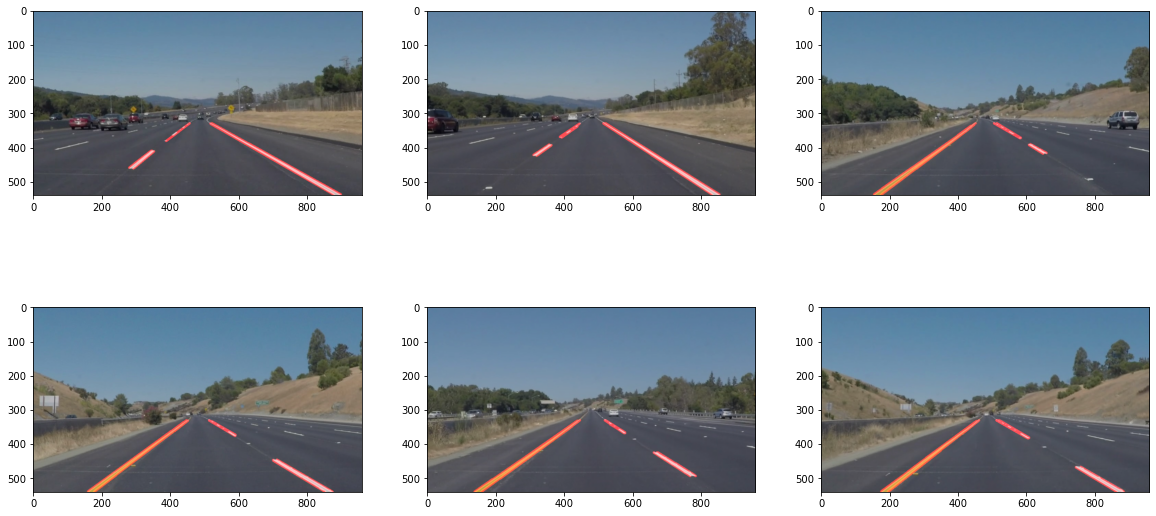

In [6]:
import glob

test_paths = glob.glob("./test_images/*.jpg")

plt.figure(figsize=(20, 10))
for i, test_path in enumerate(test_paths):
    image = mpimg.imread(test_path)
    result = lane_finding(image)
    plt.subplot(2, 3, i+1)
    plt.imshow(result)
    # mpimg.imsave('./test_images_out/' + 'result_' + str(i+1) + '.jpg', result)

* Test on "test_videos/*.mp4"

In [7]:
cap = cv2.VideoCapture('./test_videos/solidWhiteRight.mp4')

w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)  

fourcc = cv2.VideoWriter_fourcc("D", "I", "V", "X")

out = cv2.VideoWriter('./test_videos_output/soliWhiteRight_result.mp4', fourcc, fps, (w, h))

delay = round(1000/fps)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    cv2.imshow("frmae", frame)
    result = lane_finding(frame)
    cv2.imshow("result", result)
    
    key = cv2.waitKey(delay)
    if key == 27: # ESC
        break
        

if cap.isOpened():
    print("cap released")
    cap.release()
    
if out.isOpened():  
    print("out released")
    out.release()
    
cv2.destroyAllWindows()

cap released
out released
